## STERNUM

In [78]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.optimize import curve_fit
#%matplotlib notebook

## Load the orginal data

In [29]:
DF = pd.read_csv('center_sternum.txt',sep='\t')
DF['Time'] = np.arange(0, len(DF['AccX']) )/DF['Log Freq'][0]    #changed freq
DF

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk,Time
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031,0.000
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806,0.005
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827,0.010
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383,0.015
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356,82.505
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960,82.510
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502,82.515
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953,82.520


## Select only the meaningful data

New DataFrame with only the selected data:

In [30]:
a = 2500
b = 12500
df = DF.iloc[a:b+1]    
df = df.drop(['Log Mode', 'Log Freq', 'Timestamp','qw', 'qi', 'qj', 'qk'], axis=1)  
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-31.415,107.055,-943.487,-2.549618,3.908397,-1.297710,-212,-434,434,12.500
2501,-19.276,110.166,-964.227,-2.610687,4.274809,-1.099237,-212,-434,434,12.505
2502,-33.855,105.835,-950.868,-2.503817,4.076336,-1.038168,-211,-435,434,12.510
2503,-37.332,108.580,-954.650,-2.167939,3.801527,-0.946565,-212,-434,434,12.515
2504,-39.894,106.323,-951.112,-1.908397,3.755725,-1.129771,-212,-434,434,12.520
...,...,...,...,...,...,...,...,...,...,...
12496,-24.034,116.266,-924.028,-1.389313,2.290076,-0.992366,-212,-430,427,62.480
12497,-38.186,124.989,-908.046,-0.122137,3.022901,-0.854962,-212,-430,427,62.485
12498,-36.600,122.366,-916.525,1.099237,3.053435,-0.916031,-211,-430,428,62.490
12499,-35.746,125.477,-975.634,0.122137,3.725191,-1.068702,-211,-430,428,62.495


## Calibration

In [31]:
gyro_off = np.array([-2.242224,2.963463,-0.718397])
acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_off = np.array([-3.929942,-13.74679,60.67546])
magn_cal=np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_off=np.array([-95.67974,-244.9142,17.71132])

In [32]:
df[['GyroX','GyroY','GyroZ']]=df[['GyroX','GyroY','GyroZ']]+gyro_off.T
df[['AccX','AccY','AccZ']]=np.dot(df[['AccX','AccY','AccZ']],acc_cal.T)+acc_off.T
df[['MagnX','MagnY','MagnZ']]=np.dot(df[['MagnX','MagnY','MagnZ']],magn_cal.T)+magn_off.T
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
2500,-34.964327,92.555340,-886.756779,-4.791842,6.871860,-2.016107,-278.966269,-635.193303,394.788799,12.500
2501,-22.806330,95.603808,-907.593648,-4.852911,7.238272,-1.817634,-278.966269,-635.193303,394.788799,12.505
2502,-37.398683,91.378370,-894.163938,-4.746041,7.039799,-1.756565,-278.023732,-636.131431,394.788023,12.510
2503,-40.882782,94.078830,-897.962977,-4.410163,6.764990,-1.664962,-278.966269,-635.193303,394.788799,12.515
2504,-43.444481,91.870403,-894.405448,-4.150621,6.719188,-1.848168,-278.966269,-635.193303,394.788799,12.520
...,...,...,...,...,...,...,...,...,...,...
12496,-27.611238,101.523031,-867.238717,-3.631537,5.253539,-1.710763,-279.083641,-631.563601,388.682229,62.480
12497,-41.808383,110.068566,-851.195850,-2.364361,5.986364,-1.573359,-279.083641,-631.563601,388.682229,62.485
12498,-40.208817,107.510800,-859.706088,-1.142987,6.016898,-1.634428,-278.160875,-631.582595,389.560510,62.490
12499,-39.319880,110.644645,-919.058689,-2.120087,6.688654,-1.787099,-278.160875,-631.582595,389.560510,62.495


## Statistical analysis:
Mean, median, variance, standard deviation, 25th and 75th percentiles:

In [33]:
stat_df = pd.DataFrame({
    'mean'  : df.mean(),
    'median': df.median(),
    'variance': df.var(),
    'standard deviation': df.std(),
    '25% percentile' : df.quantile(q=0.25),
    '75% percentile': df.quantile(q=0.75)
    }).T
stat_df.drop(['Time'], axis=1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-33.923923,100.690798,-892.792885,-4.332070,6.652022,-1.586820,-278.782353,-633.760221,391.295077
median,-33.829042,100.846154,-893.264212,-4.394896,6.612318,-1.573359,-278.980192,-633.439856,391.293856
variance,48.912054,26.650799,208.169771,2.033915,0.517204,0.132337,1.496432,2.044601,6.020354
standard deviation,6.993715,5.162441,14.428090,1.426154,0.719169,0.363781,1.223288,1.429896,2.453641
25% percentile,-38.515794,97.321571,-901.225346,-4.929247,6.245906,-1.832901,-279.885554,-635.170051,389.548514
75% percentile,-29.291170,104.082729,-885.117986,-3.723140,6.978730,-1.344351,-278.073716,-632.501729,393.906260


Correlation coefficients:

In [34]:
M = df.loc[:,:'MagnZ'].corr()  #Pearson   coeff minore di 0.3 ha correlazione debole
M

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.207281,-0.420923,0.207533,0.007652,0.032781,-0.387136,-0.081957,0.114785
AccY,-0.207281,1.000000,0.140504,-0.041180,-0.001382,-0.133480,0.274671,0.304631,-0.466504
AccZ,-0.420923,0.140504,1.000000,-0.074725,0.125339,0.016920,0.129940,0.143495,-0.211160
GyroX,0.207533,-0.041180,-0.074725,1.000000,0.395109,0.385103,-0.061540,-0.044704,0.013871
GyroY,0.007652,-0.001382,0.125339,0.395109,1.000000,0.441398,0.014606,-0.141403,0.013838
GyroZ,0.032781,-0.133480,0.016920,0.385103,0.441398,1.000000,-0.013101,-0.078795,0.017769
MagnX,-0.387136,0.274671,0.129940,-0.061540,0.014606,-0.013101,1.000000,0.291389,-0.360987
MagnY,-0.081957,0.304631,0.143495,-0.044704,-0.141403,-0.078795,0.291389,1.000000,-0.692741
MagnZ,0.114785,-0.466504,-0.211160,0.013871,0.013838,0.017769,-0.360987,-0.692741,1.000000


## PCA

In [47]:
u,diag,v=la.svd(df[['AccX','AccY','AccZ']].T)
eigen_values= diag**2/(df.shape[0]-1)
eigen_values,u

(array([8.08649665e+05, 5.87230390e+01, 2.47864048e+01]),
 array([[-0.03767308,  0.89893391, -0.4364614 ],
        [ 0.11195496, -0.43022487, -0.89575256],
        [-0.99299891, -0.08260978, -0.08443221]]))

In [53]:
cov_mat_acc=np.cov(df[['AccX','AccY','AccZ']].T)
a,b=la.eig(cov_mat_acc)

cov_mat_gyro=np.cov(df[['GyroX','GyroY','GyroZ']].T)
c,d=la.eig(cov_mat_gyro)

cov_mat_magn=np.cov(df[['MagnX','MagnY','MagnZ']].T)
e,f=la.eig(cov_mat_magn)

In [69]:
print(a,'\n',b)
print(c,'\n',d)
print(e,'\n',f)

[219.53231838+0.j  39.88159152+0.j  24.31871407+0.j] 
 [[ 0.24365849 -0.91408607 -0.32415612]
 [-0.0619689   0.31887334 -0.94576934]
 [-0.96787933 -0.25053232 -0.02105129]]
[2.15970553+0.j 0.42813514+0.j 0.09561511+0.j] 
 [[ 0.96330418  0.26252256 -0.05591928]
 [ 0.2453253  -0.94565879 -0.21341264]
 [ 0.10890619 -0.19186287  0.97536049]]
[7.41460183+0.j 1.25420181+0.j 0.89258408+0.j] 
 [[ 0.19830703  0.98009572  0.00931123]
 [ 0.41970275 -0.09349749  0.90283322]
 [-0.88573355  0.17513023  0.42989008]]


In [57]:
rot=np.dot(df[['AccX','AccY','AccZ']],b)
rot1=np.dot(df[['GyroX','GyroY','GyroZ']],d)
rot2=np.dot(df[['MagnX','MagnY','MagnZ']],f)
dfr=pd.DataFrame({'acc_PCA1': rot[:,0], 'acc_PCA2': rot[:,1],'acc_PCA3': rot[:,2],
                    'gyro_PCA1': rot1[:,0], 'gyro_PCA2': rot1[:,1],'gyro_PCA3': rot1[:,2],
                    'magn_PCA1': rot2[:,0], 'magn_PCA2': rot2[:,1],'magn_PCA3': rot2[:,2]})

dfr['time']=df['Time'].values
dfr


,acc_PCA1,acc_PCA2,acc_PCA3,gyro_PCA1,gyro_PCA2,gyro_PCA3,magn_PCA1,magn_PCA2,magn_PCA3,time
0,844.018650,283.635072,-57.534732,-3.149727,-7.369585,-3.165017,-671.591031,-144.885213,-406.355348,12.500
1,866.959713,278.714000,-63.920326,-3.097050,-7.770198,-3.046216,-671.591031,-144.885213,-406.355348,12.505
2,850.667670,287.340711,-55.476549,-3.036141,-7.566171,-2.950271,-671.797167,-143.873861,-407.193879,12.510
3,853.328406,292.338364,-56.821195,-2.770030,-7.235695,-2.821059,-671.591031,-144.885213,-406.355348,12.515
4,849.397822,293.084493,-53.977031,-2.551201,-7.089096,-3.004490,-671.591031,-144.885213,-406.355348,12.520
...,...,...,...,...,...,...,...,...,...,...
9996,826.363445,274.883368,-68.810528,-2.395761,-5.593184,-2.586710,-664.682117,-146.409063,-405.704579,62.480
9997,806.847074,286.566466,-72.628265,-0.980341,-5.979887,-2.679944,-664.682117,-146.409063,-405.704579,62.485
9998,815.632207,286.420812,-70.548566,0.197054,-5.676406,-2.814323,-665.285021,-145.349074,-405.335571,62.490
9999,873.100759,301.477291,-72.551167,-0.596018,-6.538877,-3.051955,-665.285021,-145.349074,-405.335571,62.495


(20.0, 40.0)

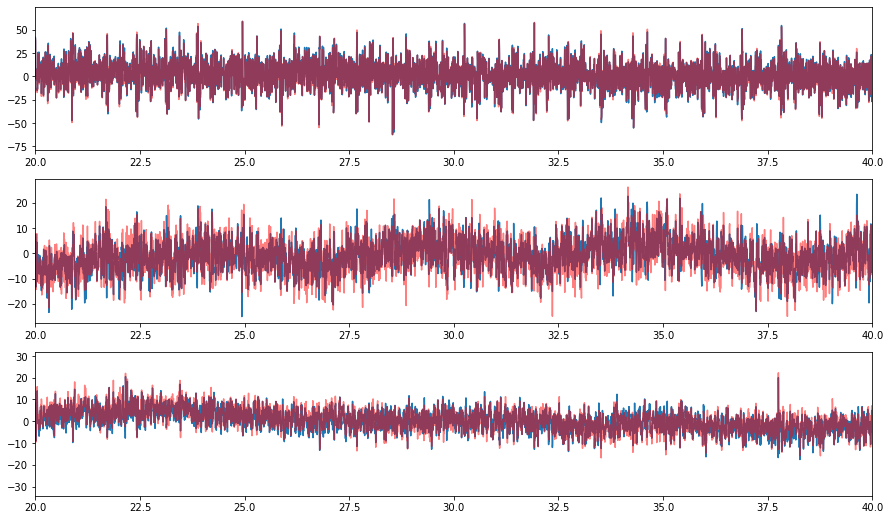

In [75]:

fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(15,9))
ax[0].plot(dfr['time'],dfr['acc_PCA1']-np.mean(dfr['acc_PCA1']))
ax[1].plot(dfr['time'],dfr['acc_PCA2']-np.mean(dfr['acc_PCA2']))
ax[2].plot(dfr['time'],dfr['acc_PCA3']-np.mean(dfr['acc_PCA3']))
ax[0].plot(df['Time'],-(df['AccZ']-np.mean(df['AccZ'])),color='red',alpha=0.5)
ax[1].plot(df['Time'],-(df['AccX']-np.mean(df['AccX'])),color='red',alpha=0.5)
ax[2].plot(df['Time'],-(df['AccY']-np.mean(df['AccY'])),color='red',alpha=0.5)
ax[0].set_xlim(20,40)
ax[1].set_xlim(20,40)
ax[2].set_xlim(20,40)


(20.0, 40.0)

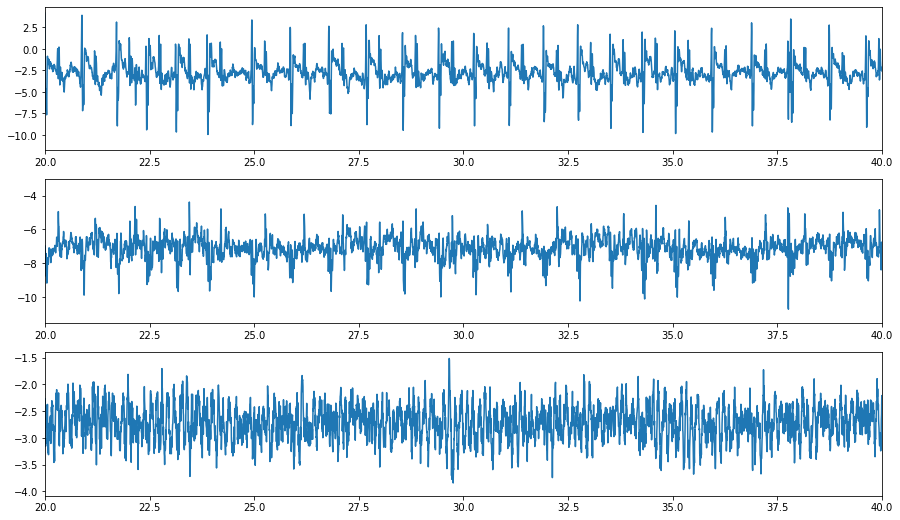

In [67]:
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(15,9))
ax[0].plot(dfr['time'],dfr['gyro_PCA1'])
ax[1].plot(dfr['time'],dfr['gyro_PCA2'])
ax[2].plot(dfr['time'],dfr['gyro_PCA3'])
ax[0].set_xlim(20,40)
ax[1].set_xlim(20,40)
ax[2].set_xlim(20,40)

(0.0, 2.0)

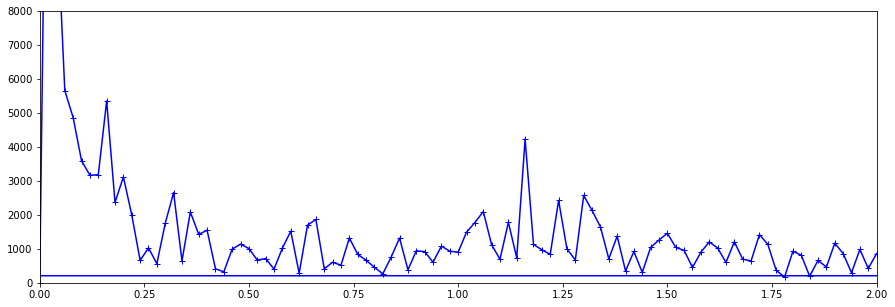

In [86]:
accxfreq=np.fft.fft(dfr['acc_PCA1']-np.mean(dfr['acc_PCA1']))
freq=np.fft.fftfreq(d=1/200, n=len(accxfreq))

#select heart-beat freq
min_f=40./60.
max_f=100./60.

plt.figure(figsize=(15,5))
plt.plot(freq,np.abs(accxfreq),'b-+')
#plt.xlim(min_f, max_f)
plt.ylim(0,8000)
plt.xlim(0, 2)

Gaussian mean:	 69.59473901783376 BPM -0.10878715369214421


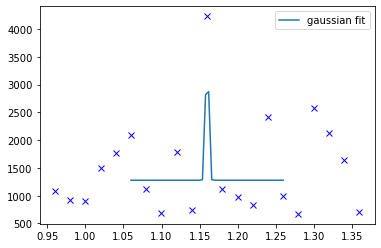

In [93]:
#for finding with gaussian interpolation the peak and his frequency-value
min_f=40./60.
max_f=100./60.

def trasf_grad(freq,mean,A,T,h): #with abs value!!
    return np.abs((A/(np.pi*(freq-mean))) * np.sin(np.pi*(freq-mean)*T))+h

def gauss(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + offset

def find_peak (x,y,height_peak,p0_gauss,range_points): #NB change p0 and height
    x_heart=[]
    y_heart=[]
    for i in range(len(x)):
        if x[i]<=max_f and x[i]>=min_f:
            x_heart.append(x[i])
            y_heart.append(y[i])
        
    peaks,_ = signal.find_peaks(y_heart, height=height_peak)
    for i in peaks:
        plt.plot(x_heart[i-range_points:i+range_points+1],y_heart[i-range_points:i+range_points+1],'bx')
        
        global popt
        popt,pcov = curve_fit(gauss,x_heart[i-range_points//2:i+range_points//2+1],y_heart[i-range_points//2:i+range_points//2+1],p0=p0_gauss, maxfev = 3000)
        x_fit=np.linspace(x_heart[i-range_points//2],x_heart[i+range_points//2])
        plt.plot(x_fit,gauss(x_fit,*popt),label='gaussian fit')
        print('Gaussian mean:\t',popt[1]*60,'BPM',popt[2]*60)
        
        #global popt2
        #popt2,pcov2 = curve_fit(trasf_grad,x_heart[i-range_points:i+range_points+1],y_heart[i-range_points:i+range_points+1],p0=[popt[1],4000,10,1000], maxfev = 3000)
        #x_fit2=np.linspace(x_heart[i-20],x_heart[i+20])
        #plt.plot(x_fit2,trasf_grad(x_fit2,*popt2),label='abs curve fit')        
        plt.legend()
        #print('Parameters:\t',popt2)
        
find_peak(freq,np.abs(accxfreq),4000,[4000,1.2,0.1, 500],10)